# Task Description

https://www.kaggle.com/datasets/jonathanoheix/face-expression-recognition-dataset

Fine-tune an existing neural network in order to classify facial expressions into different emotional categories based on image data.

Dynamically quantize the model.

Distill the model into a compact architecture, such as MobileNetV3.

# Initial Setup

In [1]:
import numpy as np
import pandas as pd
import torch

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
%matplotlib inline

from tqdm.notebook import tqdm
import os, glob

from PIL import Image
from keras.preprocessing.image import img_to_array

from torchvision import datasets, transforms
from torchvision import models
import torchinfo
from torchinfo import summary
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import DataLoader, Dataset
import torch.quantization

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

import warnings
warnings.filterwarnings('ignore')

import time

import kagglehub

import gc # garbage collect

In [2]:
# Checking videodriver
!nvidia-smi

Sun Mar  2 22:21:57 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 572.16                 Driver Version: 572.16         CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4050 ...  WDDM  |   00000000:01:00.0  On |                  N/A |
| N/A   43C    P8              4W /   79W |     546MiB /   6141MiB |      7%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
# Checking Cuda version
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Wed_Feb__8_05:53:42_Coordinated_Universal_Time_2023
Cuda compilation tools, release 12.1, V12.1.66
Build cuda_12.1.r12.1/compiler.32415258_0


In [4]:
# Checking GPU availability
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("Number of GPUs:",torch.cuda.device_count())
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")

'''
Expected output:
PyTorch version: 2.5.1+cu121
CUDA available: True
Number of GPUs: 1
GPU Name: NVIDIA GeForce RTX 4050 Laptop GPU
''';

PyTorch version: 2.5.1+cu121
CUDA available: True
Number of GPUs: 1
GPU Name: NVIDIA GeForce RTX 4050 Laptop GPU


In [5]:
# Checking if computations on GPU work
x = torch.randn(1000, 1000, device='cuda')
y = torch.matmul(x, x)
print("Computation successful on:", y.device)

'''
Expected output:
Computation successful on: cuda:0
''';

Computation successful on: cuda:0


In [6]:
device_type = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device_type)
device

device(type='cuda')

# Data Preparation and Loading

In [7]:
DATASET_DIR = 'dataset'
dataset_train_dir = DATASET_DIR + '/train'
dataset_test_dir = DATASET_DIR + '/validation'

In [8]:
transform_train = transforms.Compose([
         transforms.RandomHorizontalFlip(),
         transforms.RandomRotation(10),
         transforms.RandomResizedCrop(224, scale=(0.8, 1.0)), # Zoom 80-100 %
         transforms.Resize((224, 224)),
         transforms.ToTensor(), # Converts (H, W, C) to (C, H, W) and scales pixel values to [0, 1]
         transforms.Normalize(mean=[0.485, 0.456, 0.406], # mean and std of images from imagenet, on which Resnet-50 was taught https://pytorch.org/vision/main/models/generated/torchvision.models.resnet50.html
                              std=[0.229, 0.224, 0.225]),
])

transform_test = transforms.Compose([
         transforms.Resize((224, 224)),
         transforms.ToTensor(),
         transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225]),
])

In [9]:
class FaceExpressionDataset(Dataset):
    '''
    A class that loads images, applies augmentation and forms train and test dataset
    '''
    def __init__(self, dataset_dir, transform=None, shuffle=False):
        self.dataset_dir = dataset_dir
        self.transform = transform
        self.images = []
        self.labels = []

        # Obtaining the classes list and label-encoding
        self.classes = sorted(os.listdir(dataset_dir))
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}

        # Iterating through all images in the directory
        for cls in self.classes:
            class_dir = dataset_dir + '/' + cls
            for image_name in os.listdir(class_dir):
                image_path = class_dir + '/' + image_name
                # Saving each image as np.array
                with Image.open(image_path) as img:
                    img_rgb = img.convert('RGB') # Coverting to RGB by duplicating the black and white channel 3 times
                    self.images.append(img_rgb)
                # Saving corresponding labels for each image
                self.labels.append(self.class_to_idx[cls])

        # Shuffling train dataset in advance
        if shuffle:
            images_labels_series = pd.Series(zip(self.images, self.labels))
            images_labels_series = images_labels_series.sample(frac=1, random_state=42, ignore_index=True)
            images_labels_list = list(images_labels_series)
            self.images = list(list(zip(*images_labels_list))[0])
            self.labels = list(list(zip(*images_labels_list))[1])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        label = self.labels[idx]
        image = self.images[idx]

        # Applying transformations if they are specified
        if self.transform:
            image = self.transform(image)

        return image, label

In [10]:
dataset_train = FaceExpressionDataset(dataset_train_dir, transform=transform_train, shuffle=True)
dataset_test = FaceExpressionDataset(dataset_test_dir, transform=transform_test)

In [11]:
# Analysing train and test datasets
datasets = [dataset_train, dataset_test]
print(f'Classes: {dataset_train.class_to_idx}')
print('-'*20)
for dataset in datasets:
    print(f"{((dataset.dataset_dir).split('/')[-1]).capitalize()} dataset total length: {len(dataset)}")
        
    labels, counts = np.unique(np.array(dataset.labels), return_counts=True)
    print(f"Target value counts: {dict(zip(labels, counts))}")
    print('-'*20)

Classes: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
--------------------
Train dataset total length: 28821
Target value counts: {0: 3993, 1: 436, 2: 4103, 3: 7164, 4: 4982, 5: 4938, 6: 3205}
--------------------
Validation dataset total length: 7066
Target value counts: {0: 960, 1: 111, 2: 1018, 3: 1825, 4: 1216, 5: 1139, 6: 797}
--------------------


As we can see, in total there are 7 classes in our dataset. 

Some of them are represented by a larger amount of images than others.
For example, there are only 436 images of 'disgust' class compared to 7164 of 'happy' class in the train dataset.
Such an imbalance can potentially lead to decrease in accuracy.

In [12]:
# Ensuring the format is correct
for dataset in datasets:
    print(f"{((dataset.dataset_dir).split('/')[-1]).capitalize()} dataset:")
    image, label = dataset[0]
    print(f"Image datatype: {type(image)}")
    print(f"Tensor shape: {image.shape}")
    print('-'*20)

if (str(type(image)) == "<class 'torch.Tensor'>") and (str(image.shape) == "torch.Size([3, 224, 224])"):
    print('Correct format')

Train dataset:
Image datatype: <class 'torch.Tensor'>
Tensor shape: torch.Size([3, 224, 224])
--------------------
Validation dataset:
Image datatype: <class 'torch.Tensor'>
Tensor shape: torch.Size([3, 224, 224])
--------------------
Correct format


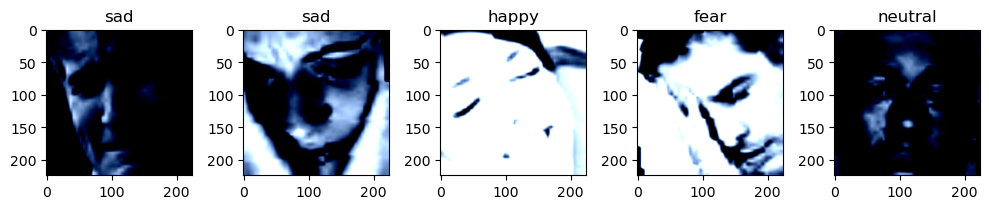

In [13]:
# Displaying some images after transformation
n = 5
index_to_label = {x[0]:x[1] for x in enumerate(dataset_train.class_to_idx)}
fig, axes = plt.subplots(1, n, figsize=(10, 5))
for i in range(n):
    image, label = dataset_train[i]
    image = image.permute(1, 2, 0).numpy()  # Converting from (C, H, W) to (H, W, C) and from tensor to array
    image = np.clip(image, 0, 1)  # Clipping values to be between 0 and 1
    
    # Plot the image
    axes[i].imshow(image)
    axes[i].set_title(str(index_to_label[label]))
    # axes[i].axis("off")
plt.tight_layout()
plt.show()

Well, I do not quite understand the logic of assigning labels to certain images. For instance, the person in picture 4 does not seem to be in fear.

I took a look at other pictures in the dataset, and some pictures are definitely mislabeled. But we have what we have.

At least now we see that augmentation and normalisation performed correctly.

In [14]:
# Instantiating dataloaders
batch_size = 32
num_workers = 0 # With values other than 0 it ended up in deadlock. Why?
train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers, drop_last=True)
test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers)

In [15]:
# Checking if train dataloader works correctly
# Expected output: torch.Size([<batch_size>, 3, 224, 224])
train_iter = iter(train_loader)
image, label = next(train_iter)
print(f"Image shape: {image.shape}") 

Image shape: torch.Size([32, 3, 224, 224])


# ResNet-50 Fine-tuning

I am going to fine-tune ResNet-50 as a neural network that has decent accuracy and is not too heavy. Initially, it was taught on Imagenet dataset which contains coloured pictures. Given that our dataset is grayscale and pictures are small, final accuracy can fall significantly.

In [16]:
# https://pytorch.org/vision/main/models/generated/torchvision.models.resnet50.html
resnet50 = models.resnet50(weights='IMAGENET1K_V2')

In [17]:
torchinfo.summary(resnet50)

Layer (type:depth-idx)                   Param #
ResNet                                   --
├─Conv2d: 1-1                            9,408
├─BatchNorm2d: 1-2                       128
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
│    └─Bottleneck: 2-1                   --
│    │    └─Conv2d: 3-1                  4,096
│    │    └─BatchNorm2d: 3-2             128
│    │    └─Conv2d: 3-3                  36,864
│    │    └─BatchNorm2d: 3-4             128
│    │    └─Conv2d: 3-5                  16,384
│    │    └─BatchNorm2d: 3-6             512
│    │    └─ReLU: 3-7                    --
│    │    └─Sequential: 3-8              16,896
│    └─Bottleneck: 2-2                   --
│    │    └─Conv2d: 3-9                  16,384
│    │    └─BatchNorm2d: 3-10            128
│    │    └─Conv2d: 3-11                 36,864
│    │    └─BatchNorm2d: 3-12            128
│    │    └─Conv2d: 3-13               

In [18]:
resnet50

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

List of all layers in ResNet-50.

conv1: The initial convolutional layer.

bn1: The batch normalization layer after the initial convolution.

relu: ReLU activation after the initial batch normalization.

maxpool: Max pooling after the ReLU activation.

layer1, layer2, layer3, layer4: The four residual blocks (each block contains multiple convolutional layers).

avgpool: Global average pooling layer.

fc: The fully connected (classification) layer.

In [19]:
# Dropping the last layer
resnet50 = nn.Sequential(*list(resnet50.children())[:-1])
torchinfo.summary(resnet50)

Layer (type:depth-idx)                   Param #
Sequential                               --
├─Conv2d: 1-1                            9,408
├─BatchNorm2d: 1-2                       128
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
│    └─Bottleneck: 2-1                   --
│    │    └─Conv2d: 3-1                  4,096
│    │    └─BatchNorm2d: 3-2             128
│    │    └─Conv2d: 3-3                  36,864
│    │    └─BatchNorm2d: 3-4             128
│    │    └─Conv2d: 3-5                  16,384
│    │    └─BatchNorm2d: 3-6             512
│    │    └─ReLU: 3-7                    --
│    │    └─Sequential: 3-8              16,896
│    └─Bottleneck: 2-2                   --
│    │    └─Conv2d: 3-9                  16,384
│    │    └─BatchNorm2d: 3-10            128
│    │    └─Conv2d: 3-11                 36,864
│    │    └─BatchNorm2d: 3-12            128
│    │    └─Conv2d: 3-13               

In [20]:
class ModifiedResNet50_TrainLastOnly(nn.Module):
    '''
    A neural network based on pretrained ResNet50 with the removed in advance fc layer.
    Only the last layer weights can be updated.
    '''
    def __init__(self):
        super().__init__()
        self.resnet50 = resnet50 # The entire network in one line
        self.fc = nn.Linear(2048, 7) # Adding the last fc linear layer
        
        for param in self.resnet50.parameters(): 
            param.requires_grad = False # Not training the existing layers
        for param in self.fc.parameters():
            param.requires_grad = True # Training the last layer

    def forward(self, x):
        # forward pass сети
        # умножение на матрицу весов 1 слоя и применение функции активации
        x = self.resnet50(x) 
        # print(x.shape)
        x = x.flatten(1)
        # print(x.shape)
        x = self.fc(x)
        return x

In [21]:
class ModifiedResNet50_TrainAll(nn.Module):
    '''
    A neural network based on pretrained ResNet50 with the removed in advance fc layer.
    The entire model weights can be updated.
    '''
    def __init__(self):
        super().__init__()
        self.resnet50 = resnet50 # The entire network in one line
        self.fc = nn.Linear(2048, 7) # Adding the last fc linear layer
        
        for param in self.resnet50.parameters(): 
            param.requires_grad = True # Training the existing layers
        for param in self.fc.parameters():
            param.requires_grad = True # Training the last layer

    def forward(self, x):
        # forward pass сети
        # умножение на матрицу весов 1 слоя и применение функции активации
        x = self.resnet50(x) 
        # print(x.shape)
        x = x.flatten(1)
        # print(x.shape)
        x = self.fc(x)
        return x

In [22]:
# Auxiliary class for printing styles
class Color():
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [23]:
def train(net, n_epochs=2):
    loss_fn = torch.nn.CrossEntropyLoss()
    learning_rate = 1e-4
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
    
    # Initialising the StepLR scheduler
    scheduler = StepLR(optimizer, step_size=10, gamma=0.1)  # Adjusting LR every 5 epochs by a factor of 0.1
    
    best_accuracy = 0
    best_number_of_epochs = 0

    # Precision, recall and f1 metrics for each class corresponding to the highest accuracy
    best_precision = []
    best_recall = []
    best_f1 = []
    
    train_loss = []
    test_loss = []
    accuracy = []
    
    counter = 0 # Number of epochs without accuracy growth
    no_progress_limit = 5 # Number of epochs with no accuracy growth after which learning should be stopped

    print(f"Number of batches in each epoch: {len(train_loader.dataset) // batch_size}.")
    for epoch in range(n_epochs):
        epoch_train_loss = []
        epoch_test_loss = []
        
        print('-'*40)
        print(f'Epoch {epoch + 1} out of {n_epochs} started.')
        print('Current batch: ', end='')
        train_iter = iter(train_loader)

        net.train(True) # enable dropout / batch_norm training behavior
        # Iterating through batches
        for i, batch in enumerate(train_iter):
            if i % 10 == 0:
                print(f'{i}', end=' ')
            
            # Obtaining current batch
            X_batch, y_batch = batch

            # Sending batch to GPU
            X_batch = X_batch.to(device, non_blocking=True)
            y_batch = y_batch.to(device, non_blocking=True)
            
            # Resetting gradients
            optimizer.zero_grad()
            
            y_pred = net(X_batch)
            loss = loss_fn(y_pred, y_batch)
            loss.backward()
            optimizer.step()   
            epoch_train_loss.append(loss.item())

        # Calculating average loss for an epoch on train dataset 
        train_loss.append(np.mean(epoch_train_loss))
        # Updating learning rate with the scheduler
        scheduler.step()
        
        net.train(False) # disable dropout / use averages for batch_norm
        with torch.no_grad():
            all_labels = []
            all_preds = []
            for batch in test_loader:
                x, y = batch
                x = x.to(device)
                y = y.to(device)
                y_pred = net(x)
                loss = loss_fn(y_pred, y)
                epoch_test_loss.append(loss.item())
                
                # Collecting true labels and predictions
                all_labels.extend(y.detach().cpu().numpy())
                all_preds.extend(np.argmax(y_pred.detach().cpu().numpy(), axis=1))

            # Calculating average accuracy for all test batches for an epoch and appending it to a list
            epoch_accuracy = np.mean(np.array([1 if a == b else 0 for a, b in zip(all_labels, all_preds)]))
            accuracy.append(epoch_accuracy)
            
            # Calculating average loss for an epoch on test dataset 
            test_loss.append(np.mean(epoch_test_loss))
            
            # Calculating precision, f1 and recall for each class
            precision = precision_score(all_labels, all_preds, average=None)
            recall = recall_score(all_labels, all_preds, average=None)
            f1 = f1_score(all_labels, all_preds, average=None)

            print()
            print(f"Accuracy at this epoch: {epoch_accuracy:.4f}")
            print(f"Train loss at this epoch: {train_loss[-1]:.2f}")
            print(f"Test loss at this epoch: {test_loss[-1]:.2f}")
            if epoch_accuracy > best_accuracy:
                best_accuracy = epoch_accuracy
                torch.save(net.state_dict(), f'./best_models/{str(net).split('(')[0]}.pt')
                # Precision, recall and f1 for each class corresponding to the best accuracy
                best_precision = list(map(lambda x: round(x, 3), precision))
                best_recall = list(map(lambda x: round(x, 3), recall))
                best_f1 = list(map(lambda x: round(x, 3), f1))
                best_number_of_epochs = epoch + 1
                
                print(f'{Color.BOLD}Best accuracy obtained: {best_accuracy:.4f}')
                print(f'Precision per class: {best_precision}')
                print(f'Recall per class: {best_recall}')
                print(f'F1 Score per class: {best_f1}{Color.END}')
            else:
                counter += 1

            # Building loss and accuracy graphs every 5 epochs to visualise the progress
            if (epoch + 1) % 5 == 0:
                    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

                    axes[0].set_title('Loss')
                    axes[0].plot(train_loss, label='train')
                    axes[0].plot(test_loss, label='test')
                    axes[0].legend()
                
                    axes[1].set_title('Test accuracy')
                    axes[1].plot(accuracy)
                
                    plt.tight_layout()
                    plt.show()
        
        if counter > no_progress_limit:
            print(f"{Color.RED}No increase in accuracy for {no_progress_limit} epochs. Training stopped.{Color.END}")
            break
        
        # Collecting garbage and emptying cache after each epoch
        gc.collect()
        torch.cuda.empty_cache()
        
    result = pd.DataFrame({'nn': [str(net).split('(')[0]],
                  'mean_accuracy': [round(best_accuracy, 3)],
                  'precision_by_class': [best_precision],
                  'recall_by_class': [best_recall],
                  'f1_by_class': [best_f1],
                  'number_of_epochs': [best_number_of_epochs]})
    return result

In [24]:
nets = [ModifiedResNet50_TrainLastOnly().to(device), ModifiedResNet50_TrainAll().to(device)]
nets[1]

ModifiedResNet50_TrainAll(
  (resnet50): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
       

Number of batches in each epoch: 900.
----------------------------------------
Epoch 1 out of 40 started.
Current batch: 0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530 540 550 560 570 580 590 600 610 620 630 640 650 660 670 680 690 700 710 720 730 740 750 760 770 780 790 800 810 820 830 840 850 860 870 880 890 
Accuracy at this epoch: 0.6605
Train loss at this epoch: 1.02
Test loss at this epoch: 0.91
Best accuracy obtained: 0.6605
Precision per class: [0.578, 0.75, 0.553, 0.876, 0.588, 0.502, 0.75]
Recall per class: [0.566, 0.108, 0.395, 0.872, 0.674, 0.589, 0.788]
F1 Score per class: [0.572, 0.189, 0.461, 0.874, 0.628, 0.542, 0.769]
----------------------------------------
Epoch 2 out of 40 started.
Current batch: 0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310

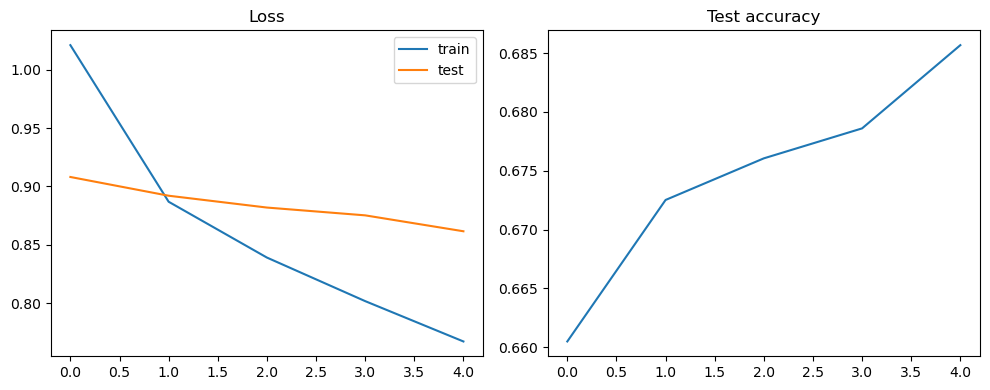

----------------------------------------
Epoch 6 out of 40 started.
Current batch: 0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530 540 550 560 570 580 590 600 610 620 630 640 650 660 670 680 690 700 710 720 730 740 750 760 770 780 790 800 810 820 830 840 850 860 870 880 890 
Accuracy at this epoch: 0.6882
Train loss at this epoch: 0.74
Test loss at this epoch: 0.87
Best accuracy obtained: 0.6882
Precision per class: [0.623, 0.825, 0.57, 0.902, 0.593, 0.56, 0.765]
Recall per class: [0.592, 0.468, 0.454, 0.865, 0.738, 0.572, 0.821]
F1 Score per class: [0.607, 0.598, 0.505, 0.883, 0.658, 0.566, 0.792]
----------------------------------------
Epoch 7 out of 40 started.
Current batch: 0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 4

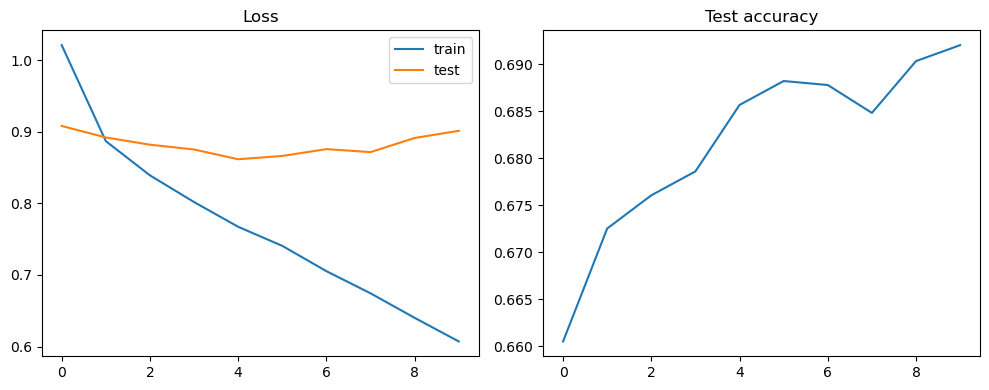

----------------------------------------
Epoch 11 out of 40 started.
Current batch: 0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530 540 550 560 570 580 590 600 610 620 630 640 650 660 670 680 690 700 710 720 730 740 750 760 770 780 790 800 810 820 830 840 850 860 870 880 890 
Accuracy at this epoch: 0.6981
Train loss at this epoch: 0.54
Test loss at this epoch: 0.88
Best accuracy obtained: 0.6981
Precision per class: [0.623, 0.818, 0.586, 0.878, 0.616, 0.567, 0.802]
Recall per class: [0.614, 0.649, 0.494, 0.894, 0.715, 0.553, 0.802]
F1 Score per class: [0.618, 0.724, 0.536, 0.886, 0.662, 0.56, 0.802]
----------------------------------------
Epoch 12 out of 40 started.
Current batch: 0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 40

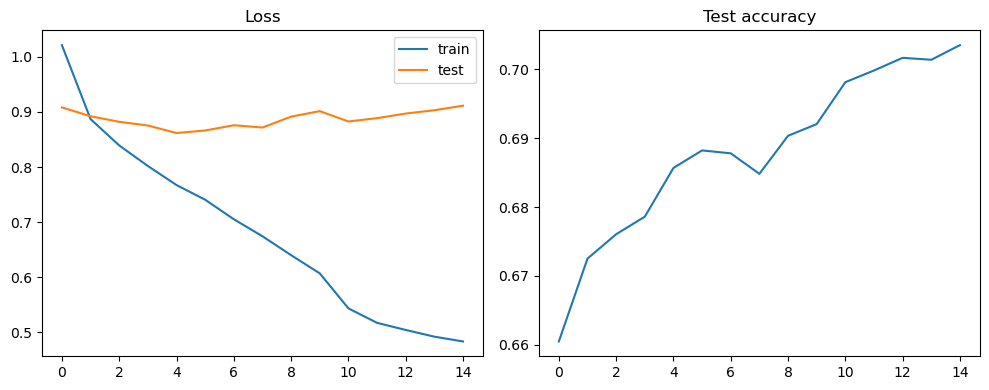

----------------------------------------
Epoch 16 out of 40 started.
Current batch: 0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530 540 550 560 570 580 590 600 610 620 630 640 650 660 670 680 690 700 710 720 730 740 750 760 770 780 790 800 810 820 830 840 850 860 870 880 890 
Accuracy at this epoch: 0.7025
Train loss at this epoch: 0.48
Test loss at this epoch: 0.91
----------------------------------------
Epoch 17 out of 40 started.
Current batch: 0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530 540 550 560 570 580 590 600 610 620 630 640 650 660 670 680 690 700 710 720 730 740 750 760 770 780 790 800 810 820 830 840 850 860 870 880 890 
Accuracy at this epoch: 0.7011
Train los

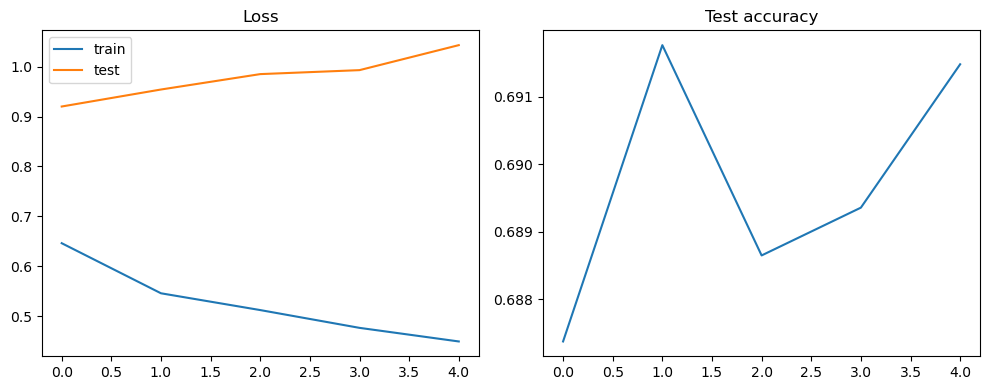

----------------------------------------
Epoch 6 out of 40 started.
Current batch: 0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530 540 550 560 570 580 590 600 610 620 630 640 650 660 670 680 690 700 710 720 730 740 750 760 770 780 790 800 810 820 830 840 850 860 870 880 890 
Accuracy at this epoch: 0.6864
Train loss at this epoch: 0.42
Test loss at this epoch: 1.07
----------------------------------------
Epoch 7 out of 40 started.
Current batch: 0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530 540 550 560 570 580 590 600 610 620 630 640 650 660 670 680 690 700 710 720 730 740 750 760 770 780 790 800 810 820 830 840 850 860 870 880 890 
Accuracy at this epoch: 0.6845
Train loss 

In [34]:
results = pd.DataFrame()
for i, net in enumerate(nets):
    # Collecting garbage
    gc.collect()
    torch.cuda.empty_cache()

    # Training neural networks
    results = pd.concat([results, train(net, n_epochs=40)], ignore_index=True)

    # Saving the results
    results.to_csv('results.csv', index=False)

## Analysis of Results

In [25]:
results = pd.read_csv('results.csv')
results

,nn,mean_accuracy,precision_by_class,recall_by_class,f1_by_class,number_of_epochs
0,ModifiedResNet50_TrainLastOnly,0.704,"[0.621, 0.822, 0.602, 0.888, 0.618, 0.571, 0.808]","[0.621, 0.667, 0.521, 0.894, 0.715, 0.543, 0.817]","[0.621, 0.736, 0.558, 0.891, 0.663, 0.557, 0.812]",15
1,ModifiedResNet50_TrainAll,0.692,"[0.609, 0.828, 0.533, 0.902, 0.646, 0.576, 0.767]","[0.645, 0.649, 0.532, 0.845, 0.674, 0.571, 0.806]","[0.626, 0.727, 0.533, 0.873, 0.66, 0.573, 0.786]",2


In the table above are the results of testing two approaches: updating weights of the last linear layer only and updating the entire network weights. In either case the batch size was equal to 32, the number of epochs was limited to 40, but training interrupted earlier after 5 consecutive epochs of no improvement. 

As a loss function was utilised CrossEntropy, Adam used as an optimiser, and StepLR as a learning rate scheduler. Augmentation was applied to the train dataset.

-------

As we can see, the results are quite similar, with the mean accuracy of the first approach slightly higher than that of the second one (0.704 against 0.692).

It is also remarkable that the number of epochs to achieve best accuracy was considerably higher when training the last layer only: 15 epochs compared to 2 in the second case.

The highest precision as well as the highest recall is obtained for class 'happy', which means this is the emotion our network can identify best.

The lowest recall is for class 'fear', i.e. it has the highest number of type II errors.
The lowest precision is for class 'sad', thus it has the highest number of type I errors.

-----

Unlike the second case, where during the training process test loss was growing slightly, but accuracy was just fluctuating; in the first case, train loss was steadily going down, while test loss was barely changing. At the same time, mean accuracy was gradually growing.

This might indicate that the model had already been well-trained from the very beginning and no much space for improvement had been left, or some parameters were not optimal.

Behind the scenes, I tested AdamW instead of Adam, CosineAnnealingLR instead of StepLR and CrossEntropyLoss with label smoothing, as well as tried introducing dropout layer before the fully-connected one. In all cases, the results and metrics were almost the same, so I did not include them in the final version of notebook.

Given that all approches showed the same results, it is unlikely that changing some parameters can significantly improve final metrics (at least on ResNet50). 

It is also worth mentioning that the dataset is far from being perfect, some images seem to be mislabeled, contain inscriptions and even cartoon characters, which could have negatively affected the final results. I barely can classify them correctly myself.


# Network Compression

## Dynamic Quantization

I am to dynamically quantize pretrained ResNet50 and see how it will be affected.

In [26]:
# Instantiating ModifiedResNet50_TrainLastOnly and loading its weights
net = ModifiedResNet50_TrainLastOnly()
state_dict_path = f'./best_models/ModifiedResNet50_TrainLastOnly.pt'
net.load_state_dict(torch.load(state_dict_path, weights_only=True))
net.eval()
net.to(device)

ModifiedResNet50_TrainLastOnly(
  (resnet50): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
  

In [27]:
# Dynamically quantizing our model
quantized_net = torch.quantization.quantize_dynamic(net, {nn.LSTM, nn.Linear}, dtype=torch.qint8)
torch.save(quantized_net.state_dict(), './best_models/QuantizedModel.pt')

Dynamical quantization was succesfully applied to the ModifiedResNet50_TrainLastOnly network.

Analysis of results is in the Model Comparison section.

## Knowledge Distillation

I am going to distill ModifiedResNet50_TrainLastOnly to MobileNetV3-Small.

In [27]:
# Uploading MobileNetV3-Small with pretrained weights as a student and removing the last fc layer
student = models.mobilenet_v3_small(weights='IMAGENET1K_V1')
student = nn.Sequential(*list(student.children())[:-1])
torchinfo.summary(student)

Layer (type:depth-idx)                             Param #
Sequential                                         --
├─Sequential: 1-1                                  --
│    └─Conv2dNormActivation: 2-1                   --
│    │    └─Conv2d: 3-1                            432
│    │    └─BatchNorm2d: 3-2                       32
│    │    └─Hardswish: 3-3                         --
│    └─InvertedResidual: 2-2                       --
│    │    └─Sequential: 3-4                        744
│    └─InvertedResidual: 2-3                       --
│    │    └─Sequential: 3-5                        3,864
│    └─InvertedResidual: 2-4                       --
│    │    └─Sequential: 3-6                        5,416
│    └─InvertedResidual: 2-5                       --
│    │    └─Sequential: 3-7                        13,736
│    └─InvertedResidual: 2-6                       --
│    │    └─Sequential: 3-8                        57,264
│    └─InvertedResidual: 2-7                       --
│    │ 

In [28]:
class Mobilenet_v3_Small(nn.Module):
    '''
    A neural network based on pretrained Mobilenet_v3 with the removed in advance fc layer.
    The entire model weights can be updated.
    '''
    def __init__(self):
        super().__init__()
        self.student = student # The entire network in one line
        self.fc = nn.Linear(576, 7) # Adding the last fc linear layer
        
        for param in self.student.parameters(): 
            param.requires_grad = True # Training the existing layers
        for param in self.fc.parameters():
            param.requires_grad = True # Training the last layer

    def forward(self, x):
        # forward pass сети
        # умножение на матрицу весов 1 слоя и применение функции активации
        x = self.student(x) 
        # print(x.shape)
        x = x.flatten(1)
        # print(x.shape)
        x = self.fc(x)
        return x

In [29]:
# Large pretrained neural network ModifiedResNet50_TrainLastOnly as a teacher
teacher = net
teacher.eval()
teacher.to(device)

# MobileNet_V3_Small with pretrained weights as a student
student = Mobilenet_v3_Small()
student.train()
student.to(device)

Mobilenet_v3_Small(
  (student): Sequential(
    (0): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
            (activation): ReLU()
            (scale_activation): Hardsigmoid()
          )
          (2): Conv2

In [30]:
# Luckily we have GPT to help me with soft targets loss
class DistillationLoss(nn.Module):
    '''
    Loss function used in distillation algorithm. 
    It returns combined loss based on soft targets loss and hard labels loss with equal contribution (alpha=0.5).
    '''
    def __init__(self, alpha=0.5, temperature=3):
        super().__init__()
        self.alpha = alpha  # Balance between soft and hard targets
        self.temperature = temperature
        self.kl_div = nn.KLDivLoss(reduction="batchmean")
        self.ce_loss = nn.CrossEntropyLoss()

    def forward(self, student_logits, teacher_logits, labels):
        # Soft targets loss (KLD)
        soft_targets = nn.functional.log_softmax(student_logits / self.temperature, dim=1)
        soft_labels = nn.functional.softmax(teacher_logits / self.temperature, dim=1)
        distill_loss = self.kl_div(soft_targets, soft_labels) * (self.temperature ** 2)

        # Hard labels loss (CE)
        ce_loss = self.ce_loss(student_logits, labels)

        # Combined loss
        return self.alpha * ce_loss + (1 - self.alpha) * distill_loss

In [31]:
def distillation_train(teacher, student, n_epochs=2):
    '''
    A function that trains a student model based on a teacher model.
    It is essentially similar to the previous train function, but utilises manually written DistillationLoss.
    '''    
    name = 'DistilledModel'
    loss_fn = DistillationLoss()
    optimizer = torch.optim.Adam(student.parameters(), lr=1e-4)
    
    # Initializing the StepLR scheduler
    scheduler = StepLR(optimizer, step_size=10, gamma=0.1)  # Adjusting learning rate by 0.1 every 10 epochs
    
    best_accuracy = 0
    best_number_of_epochs = 0
    best_precision, best_recall, best_f1 = [], [], []

    train_loss, test_loss, accuracy = [], [], []
    
    counter = 0  # Number of epochs without accuracy improvement
    no_progress_limit = 5  # Early stopping after no improvement

    print(f"Number of batches in each epoch: {len(train_loader.dataset) // batch_size}.")
    
    for epoch in range(n_epochs):
        epoch_train_loss = []
        epoch_test_loss = []
        
        print('-' * 40)
        print(f'Epoch {epoch + 1}/{n_epochs} started.')
        print('Current batch: ', end='')
        
        train_iter = iter(train_loader)
        
        student.train()  # Enable training mode (dropout, batchnorm)
        for i, batch in enumerate(train_iter):
            if i % 10 == 0:
                print(f'{i}', end=' ')
            
            # Loading and moving batch data to GPU
            X_batch, y_batch = batch
            X_batch, y_batch = X_batch.to(device, non_blocking=True), y_batch.to(device, non_blocking=True)
            
            # Resetting gradients
            optimizer.zero_grad()
            
            # Forward pass
            y_pred = student(X_batch)
            teacher_logits = teacher(X_batch)  # Teacher's predictions (no gradients needed)
            
            # Compute loss
            loss = loss_fn(y_pred, teacher_logits, y_batch)
            loss.backward()
            optimizer.step()
            
            epoch_train_loss.append(loss.item())

        # Calculating and recording the average training loss for the epoch
        train_loss.append(np.mean(epoch_train_loss))
        
        # Updating learning rate scheduler
        scheduler.step()
        
        student.eval()  # Set to evaluation mode (turn off dropout, use batchnorm averages)
        with torch.no_grad():
            all_labels, all_preds = [], []
            epoch_test_loss = []
            
            for batch in test_loader:
                x, y = batch
                x, y = x.to(device), y.to(device)
                y_pred = student(x)
                loss = loss_fn(y_pred, teacher(x), y)  # Computing loss using teacher's outputs
                epoch_test_loss.append(loss.item())
                
                # Collecting true labels and predictions
                all_labels.extend(y.detach().cpu().numpy())
                all_preds.extend(np.argmax(y_pred.detach().cpu().numpy(), axis=1))
            
            # Calculating metrics for the test set
            epoch_accuracy = np.mean(np.array([1 if a == b else 0 for a, b in zip(all_labels, all_preds)]))
            accuracy.append(epoch_accuracy)

            # Calculating average loss for an epoch on test dataset 
            test_loss.append(np.mean(epoch_test_loss))
            
            # Calculating precision, f1 and recall for each class
            precision = precision_score(all_labels, all_preds, average=None)
            recall = recall_score(all_labels, all_preds, average=None)
            f1 = f1_score(all_labels, all_preds, average=None)

            print(f'\nAccuracy at epoch {epoch + 1}: {epoch_accuracy:.4f}')
            print(f'Train loss at epoch {epoch + 1}: {train_loss[-1]:.2f}')
            print(f'Test loss at epoch {epoch + 1}: {test_loss[-1]:.2f}')
            
            # If accuracy improved, saving the model and updating best metrics
            if epoch_accuracy > best_accuracy:
                best_accuracy = epoch_accuracy
                torch.save(student.state_dict(), f'./best_models/{name}.pt')
                
                # Precision, recall and f1 for each class corresponding to the best accuracy
                best_precision = list(map(lambda x: round(x, 3), precision))
                best_recall = list(map(lambda x: round(x, 3), recall))
                best_f1 = list(map(lambda x: round(x, 3), f1))
                best_number_of_epochs = epoch + 1
                
                print(f'{Color.BOLD}Best accuracy obtained: {best_accuracy:.4f}')
                print(f'Precision per class: {best_precision}')
                print(f'Recall per class: {best_recall}')
                print(f'F1 Score per class: {best_f1}{Color.END}')
            else:
                counter += 1

            # Plotting loss and accuracy graphs every 5 epochs
            if (epoch + 1) % 5 == 0:
                fig, axes = plt.subplots(1, 2, figsize=(10, 4))
                axes[0].set_title('Loss')
                axes[0].plot(train_loss, label='train')
                axes[0].plot(test_loss, label='test')
                axes[0].legend()

                axes[1].set_title('Test accuracy')
                axes[1].plot(accuracy)
                
                plt.tight_layout()
                plt.show()
        
        # Early stopping if no progress after no_progress_limit epochs
        if counter > no_progress_limit:
            print(f"{Color.RED}No accuracy improvement for {no_progress_limit} epochs. Training stopped.{Color.END}")
            break
        
        # Collecting garbage and emptying cache after each epoch
        gc.collect()
        torch.cuda.empty_cache()
    
    result_distillation = pd.DataFrame({
        'nn': [name],
        'mean_accuracy': [round(best_accuracy, 3)],
        'precision_by_class': [best_precision],
        'recall_by_class': [best_recall],
        'f1_by_class': [best_f1],
        'number_of_epochs': [best_number_of_epochs]
    })
    
    return result_distillation


Number of batches in each epoch: 900.
----------------------------------------
Epoch 1/40 started.
Current batch: 0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530 540 550 560 570 580 590 600 610 620 630 640 650 660 670 680 690 700 710 720 730 740 750 760 770 780 790 800 810 820 830 840 850 860 870 880 890 
Accuracy at epoch 1: 0.5751
Train loss at epoch 1: 2.07
Test loss at epoch 1: 1.41
Best accuracy obtained: 0.5751
Precision per class: [0.435, 0.0, 0.385, 0.791, 0.544, 0.431, 0.707]
Recall per class: [0.392, 0.0, 0.311, 0.844, 0.561, 0.538, 0.671]
F1 Score per class: [0.412, 0.0, 0.344, 0.817, 0.552, 0.479, 0.689]
----------------------------------------
Epoch 2/40 started.
Current batch: 0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 38

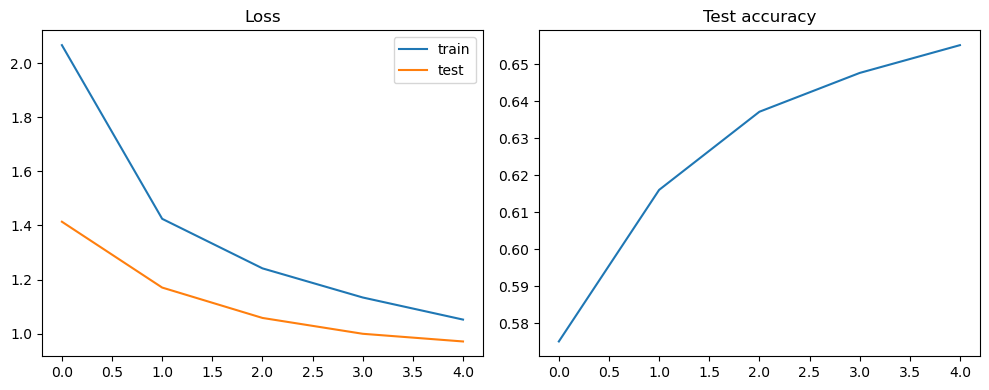

----------------------------------------
Epoch 6/40 started.
Current batch: 0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530 540 550 560 570 580 590 600 610 620 630 640 650 660 670 680 690 700 710 720 730 740 750 760 770 780 790 800 810 820 830 840 850 860 870 880 890 
Accuracy at epoch 6: 0.6628
Train loss at epoch 6: 0.99
Test loss at epoch 6: 0.94
Best accuracy obtained: 0.6628
Precision per class: [0.592, 0.79, 0.511, 0.881, 0.603, 0.517, 0.767]
Recall per class: [0.551, 0.441, 0.482, 0.851, 0.66, 0.576, 0.757]
F1 Score per class: [0.571, 0.566, 0.496, 0.866, 0.63, 0.545, 0.762]
----------------------------------------
Epoch 7/40 started.
Current batch: 0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 4

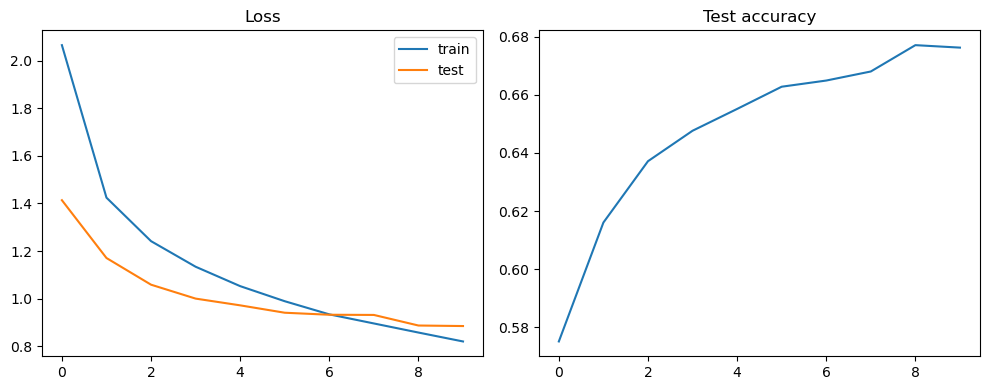

----------------------------------------
Epoch 11/40 started.
Current batch: 0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530 540 550 560 570 580 590 600 610 620 630 640 650 660 670 680 690 700 710 720 730 740 750 760 770 780 790 800 810 820 830 840 850 860 870 880 890 
Accuracy at epoch 11: 0.6826
Train loss at epoch 11: 0.77
Test loss at epoch 11: 0.84
Best accuracy obtained: 0.6826
Precision per class: [0.59, 0.75, 0.569, 0.873, 0.597, 0.56, 0.799]
Recall per class: [0.61, 0.568, 0.452, 0.879, 0.706, 0.558, 0.772]
F1 Score per class: [0.6, 0.646, 0.504, 0.876, 0.647, 0.559, 0.785]
----------------------------------------
Epoch 12/40 started.
Current batch: 0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460

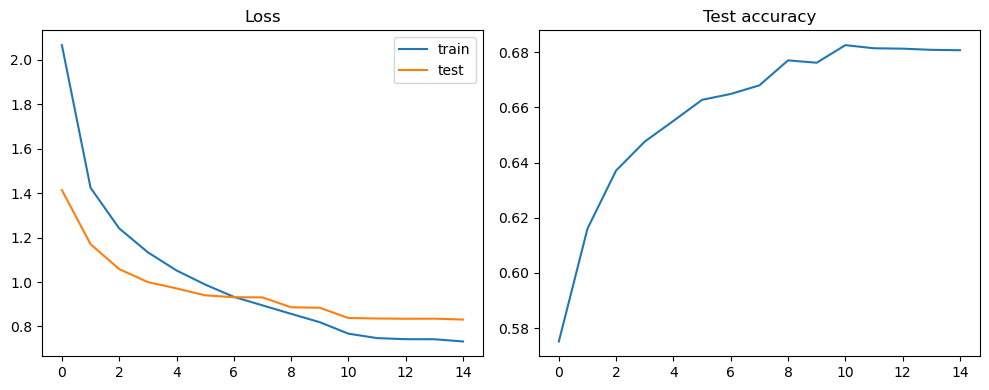

----------------------------------------
Epoch 16/40 started.
Current batch: 0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530 540 550 560 570 580 590 600 610 620 630 640 650 660 670 680 690 700 710 720 730 740 750 760 770 780 790 800 810 820 830 840 850 860 870 880 890 
Accuracy at epoch 16: 0.6816
Train loss at epoch 16: 0.73
Test loss at epoch 16: 0.83
No accuracy improvement for 5 epochs. Training stopped.


In [84]:
# Collecting garbage
gc.collect()
torch.cuda.empty_cache()

# Distilling the neural network
results_distillation = distillation_train(teacher, student, n_epochs=40)

# Saving the results
results_distillation.to_csv('results_distillation.csv', index=False)

In [33]:
results_distillation = pd.read_csv('results_distillation.csv')
results_distillation

,nn,mean_accuracy,precision_by_class,recall_by_class,f1_by_class,number_of_epochs
0,DistilledModel,0.683,"[0.59, 0.75, 0.569, 0.873, 0.597, 0.56, 0.799]","[0.61, 0.568, 0.452, 0.879, 0.706, 0.558, 0.772]","[0.6, 0.646, 0.504, 0.876, 0.647, 0.559, 0.785]",11


MobileNetV3-Small was succesfully taught by distilling knowledge from ModifiedResNet50_TrainLastOnly network.

Analysis of results is in the next section.

## Model Comparison

In this section, I am going to compare three neural networks: ModifiedResNet50_TrainLastOnly, the same model with applied dynamic quantization and ModifiedResNet50_TrainLastOnly distilled to MobileNetV3-Small.

In [34]:
# Summary for ModifiedResNet50_TrainLastOnly
summary(net, input_size=(32, 3, 224, 224), device="cuda")

Layer (type:depth-idx)                        Output Shape              Param #
ModifiedResNet50_TrainLastOnly                [32, 7]                   --
├─Sequential: 1-1                             [32, 2048, 1, 1]          --
│    └─Conv2d: 2-1                            [32, 64, 112, 112]        (9,408)
│    └─BatchNorm2d: 2-2                       [32, 64, 112, 112]        (128)
│    └─ReLU: 2-3                              [32, 64, 112, 112]        --
│    └─MaxPool2d: 2-4                         [32, 64, 56, 56]          --
│    └─Sequential: 2-5                        [32, 256, 56, 56]         --
│    │    └─Bottleneck: 3-1                   [32, 256, 56, 56]         (75,008)
│    │    └─Bottleneck: 3-2                   [32, 256, 56, 56]         (70,400)
│    │    └─Bottleneck: 3-3                   [32, 256, 56, 56]         (70,400)
│    └─Sequential: 2-6                        [32, 512, 28, 28]         --
│    │    └─Bottleneck: 3-4                   [32, 512, 28, 28]      

In [35]:
# Summary for MobileNetV3-Small
summary(student, input_size=(32, 3, 224, 224), device="cuda")

Layer (type:depth-idx)                                  Output Shape              Param #
Mobilenet_v3_Small                                      [32, 7]                   --
├─Sequential: 1-1                                       [32, 576, 1, 1]           --
│    └─Sequential: 2-1                                  [32, 576, 7, 7]           --
│    │    └─Conv2dNormActivation: 3-1                   [32, 16, 112, 112]        464
│    │    └─InvertedResidual: 3-2                       [32, 16, 56, 56]          744
│    │    └─InvertedResidual: 3-3                       [32, 24, 28, 28]          3,864
│    │    └─InvertedResidual: 3-4                       [32, 24, 28, 28]          5,416
│    │    └─InvertedResidual: 3-5                       [32, 40, 14, 14]          13,736
│    │    └─InvertedResidual: 3-6                       [32, 40, 14, 14]          57,264
│    │    └─InvertedResidual: 3-7                       [32, 40, 14, 14]          57,264
│    │    └─InvertedResidual: 3-8       

In [36]:
def load_weights_and_evaluate(net, name, state_dict_path, device='cuda') -> pd.DataFrame:
    '''
    A function that uploads weights for a passed instantiated neural network from a state_dict and returns its metrics and other characteristics on inference.
    '''
    net.load_state_dict(torch.load(state_dict_path, weights_only=True, map_location=device))
    net.eval()
    net.to(device)

    net.train(False) # disable dropout / use averages for batch_norm
    
    start_time = time.perf_counter()
    with torch.no_grad():
        all_labels = []
        all_preds = []
        for batch in test_loader:
            x, y = batch
            x = x.to(device)
            y = y.to(device)
            y_pred = net(x)
            
            # Collecting true labels and predictions
            all_labels.extend(y.detach().cpu().numpy())
            all_preds.extend(np.argmax(y_pred.detach().cpu().numpy(), axis=1))
            
    end_time = time.perf_counter()
    inference_time = round(end_time - start_time, 2)
    
    # Collecting garbage and emptying cache just in case
    gc.collect()
    torch.cuda.empty_cache()
    
    # Calculating average accuracy for all images in the test dataset
    accuracy = round(np.mean(np.array([1 if a == b else 0 for a, b in zip(all_labels, all_preds)])), 3)
    
    # Calculating precision, f1 and recall for each class
    precision = precision_score(all_labels, all_preds, average=None)
    recall = recall_score(all_labels, all_preds, average=None)
    f1 = f1_score(all_labels, all_preds, average=None)

    precision = list(map(lambda x: round(x, 2), precision))
    recall = list(map(lambda x: round(x, 2), recall))
    f1 = list(map(lambda x: round(x, 2), f1))

    # Obtaining model size
    size = os.path.getsize(state_dict_path) / 1e3

    print(f"Name: {name}")
    print('Size (KB):', size)
    print('Time (sec):', inference_time)
    print(f"Average accuracy: {accuracy}")
    print(f'Precision per class: {precision}')
    print(f'Recall per class: {recall}')
    print(f'F1 Score per class: {f1}')
    print('-'*40)

    performance_results = pd.DataFrame({'name': [name],
                                      'size_KB': [size],
                                      'time_sec': [inference_time],
                                      'accuracy': [accuracy],
                                      'precision_by_class': [precision],
                                      'recall_by_class': [recall],
                                      'f1_by_class': [f1]})
    return performance_results

In [116]:
networks = {'ModifiedResNet50': [net, 
                                 'ModifiedResNet50', 
                                 './best_models/ModifiedResNet50_TrainLastOnly.pt', 
                                 'cuda'],
            'DistilledModel': [student, 
                               'DistilledModel', 
                               './best_models/DistilledModel.pt', 
                               'cuda'],
            'QuantizedModel': [quantized_net, 
                               'QuantizedModel', 
                               './best_models/QuantizedModel.pt', 
                               'cpu']}

performance_results = pd.DataFrame()
for network in networks:
    performance_results = pd.concat([performance_results, load_weights_and_evaluate(*networks[network])], ignore_index=True)

# Saving results
performance_results.to_csv('performance_results.csv', index=False)

Name: ModifiedResNet50
Size (KB): 94420.09
Time (sec): 22.7
Average accuracy: 0.704
Precision per class: [0.62, 0.82, 0.6, 0.89, 0.62, 0.57, 0.81]
Recall per class: [0.62, 0.67, 0.52, 0.89, 0.72, 0.54, 0.82]
F1 Score per class: [0.62, 0.74, 0.56, 0.89, 0.66, 0.56, 0.81]
----------------------------------------
Name: DistilledModel
Size (KB): 3859.016
Time (sec): 7.07
Average accuracy: 0.683
Precision per class: [0.59, 0.75, 0.57, 0.87, 0.6, 0.56, 0.8]
Recall per class: [0.61, 0.57, 0.45, 0.88, 0.71, 0.56, 0.77]
F1 Score per class: [0.6, 0.65, 0.5, 0.88, 0.65, 0.56, 0.78]
----------------------------------------
Name: QuantizedModel
Size (KB): 94369.048
Time (sec): 215.79
Average accuracy: 0.705
Precision per class: [0.62, 0.82, 0.6, 0.89, 0.62, 0.57, 0.81]
Recall per class: [0.62, 0.68, 0.52, 0.89, 0.72, 0.55, 0.82]
F1 Score per class: [0.62, 0.74, 0.56, 0.89, 0.66, 0.56, 0.81]
----------------------------------------


In [37]:
performance_results = pd.read_csv('performance_results.csv')
performance_results

,name,size_KB,time_sec,accuracy,precision_by_class,recall_by_class,f1_by_class
0,ModifiedResNet50,94420.090,22.70,0.704,"[0.62, 0.82, 0.6, 0.89, 0.62, 0.57, 0.81]","[0.62, 0.67, 0.52, 0.89, 0.72, 0.54, 0.82]","[0.62, 0.74, 0.56, 0.89, 0.66, 0.56, 0.81]"
1,DistilledModel,3859.016,7.07,0.683,"[0.59, 0.75, 0.57, 0.87, 0.6, 0.56, 0.8]","[0.61, 0.57, 0.45, 0.88, 0.71, 0.56, 0.77]","[0.6, 0.65, 0.5, 0.88, 0.65, 0.56, 0.78]"
2,QuantizedModel,94369.048,215.79,0.705,"[0.62, 0.82, 0.6, 0.89, 0.62, 0.57, 0.81]","[0.62, 0.68, 0.52, 0.89, 0.72, 0.55, 0.82]","[0.62, 0.74, 0.56, 0.89, 0.66, 0.56, 0.81]"


As we can see from the table above, Dynamic Quantization did not perform well because it compresses only LSTM and Linear layers, and ResNet-50 has only one such. 

Final metrics of the model did not change anyhow. Its param size remained almost the same. Essentically, we gained no benefits from quantizing, but got one significant drawback - dynamically quantized models cannot be run on GPU, so the inference time increased by almost 10 times: from 22.7 sec to 215.79 sec.

In general, it is pointless to quantize models with a little number of LSTM and Linear layers.

----

In contrast, by applying Knowledge Distillation, we managed to decrease param size and estimated total size (see summary above) considerably: by 24.5 and 7.8 times respectively. 
In absolute values: param size dropped from 94420.09 KB to 3859.02 KB, estimated total size decreased from 5803.72 MB to 747.07 MB. This enables to run the neural network even on weak computers.

Inference time has also decreased, from 22.7 sec to 7.07 sec (3.2 times).

Accuracy went from 0.704 to 0.683 (3% difference), which is insignificant.

# Summary

In this notebook, I fine-tuned ResNet-50 Neural Network to recognise face expressions, as well as tested Dynamic Quantization and Knowledge Distillation.

---------

I tried two approaches to fine-tuning ResNet-50 neural network: updating weights of the last linear layer only and updating the entire network weights.

The parameters were as follows: batch size = 32, max number of epochs = 40. 
As a loss function was utilised CrossEntropy, Adam used as an optimiser, and StepLR as a learning rate scheduler. Augmentation was applied to the train dataset.

The results were quite similar with the maximum accuracy of 0.704 on the 15th epoch.

Class 'happy' has both highest precision and recall, which means this is the emotion our network can identify best.
The lowest recall is for class 'fear', i.e. it has the highest number of type II errors.
The lowest precision is for class 'sad', thus it has the highest number of type I errors.

Based on the behaviour of train loss and test loss, I can assume that the model had already been well-trained from the very beginning and no much space for improvement had been left.

Behind the scenes, AdamW optimiser, CosineAnnealingLR scheduler, CrossEntropyLoss with label smoothing, and dropout layer before fc was tested. In all cases, the results and metrics were almost the same, thus further improvement in metrics on ResNet-50 seems to be unlikely.

---------

Dynamic Quantization did not perform well on ResNet-50 because of its low number of LSTM and Linear layers. It only blocked GPU usage on inference. Alternatively, Static Quantization could have given better results.

---------

After applying Knowledge Distillation (ResNet-50 as a teacher, MobileNetV3-Small as a student), param size dropped from 94420.09 KB to 3859.02 KB (24.5 times), estimated total size decreased from 5803.72 MB to 747.07 MB (7.8 times), inference time decreased from 22.7 sec to 7.07 sec (3.2 times). 

At the same time, accuracy went from 0.704 to 0.683 (3% difference).

In general, Knowledge Distillation algorithm has proven well and can be utilised to run the neural network on weak computers.